# Micrograd from scratch


## References

[1] [The spelled-out intro to neural networks and backpropagation: building micrograd](https://www.youtube.com/watch?v=VMj-3S1tku0&t=862s&ab_channel=AndrejKarpathy)

[2] [
karpathy /
micrograd ](https://github.com/karpathy/micrograd)

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt

## Understanding derivatives

In [3]:
def f(x):
    return 3 * x ** 2 -4 * x + 5

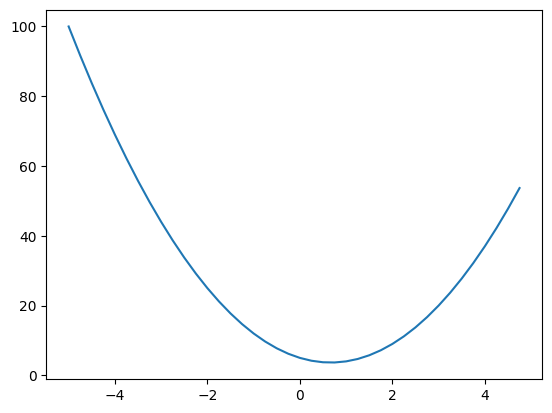

In [4]:
x = np.arange(-5, 5, 0.25)
y = f(x)

plt.plot(x, y)

In [5]:
h = 0.00000001
x = 3.0
(f(x + h) - f(x)) / h

14.00000009255109

In [6]:
h = 0.00000001
x = -3.0
(f(x + h) - f(x)) / h

-22.00000039920269

In [7]:
h = 0.00000001
x = 2 / 3
(f(x + h) - f(x)) / h

0.0

In [8]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(d)

4.0


In [9]:
h = 0.00000001

a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c
c += h
d2 = a * b + c
print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1) / h)

d1 4.0
d2 4.000000010000001
slope 1.000000082740371


## `Value` class

In [10]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0 # 0 means no effect
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self, ), "tanh")

        return out

In [11]:
a = Value(2.0 , label="a") 
b = Value(-3.0, label="b")
c = Value(10.0, label="c") 
e = a * b; e.label="e"
d = e + c; d.label="d"
f = Value(-2.0, label="f")
L = d * f; L.label="L"

In [12]:
L._prev

{Value(data=-2.0), Value(data=4.0)}

In [13]:
L._op

'*'

## Visualization of the computation graph

In [14]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)

    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})

    nodes, edges = trace(root)

    for n in nodes:
        uid = str(id(n))
        # for any value in the graph create a rectangular "record" node for it
        dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad, ), shape="record")

        if n._op:
            # if this value is a result of some operation, create an operation node for it
            dot.node(name=uid + n._op, label=n._op)

            # connect this node to it
            dot.edge(uid + n._op, uid)
        
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op) 

    return dot

ModuleNotFoundError: No module named 'graphviz'

In [ ]:
draw_dot(L)

## Manual backpropagation (example 1)

In [ ]:
L.grad = 1
d.grad = f.data
f.grad = d.data
c.grad = -2-0
e.grad = -2.0
a.grad = 6.0
b.grad = -4.0

In [ ]:
draw_dot(L)

## Manual backpropagation (example 2, a neuron)

In [ ]:
# Inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# neuron weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# neuron bias
b = Value(6.88127358701, label="b")

# Forward pass
w1x1 = w1 * x1; w1x1.label="w1 * x1"
w2x2 = w2 * x2; w2x2.label="w2 * x2"
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label="w1 * x1 + w2 * x2"
n = w1x1w2x2 + b; n.label="n"

# apply activation function
o = n.tanh(); o.label="o"

In [ ]:
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid()

In [ ]:
draw_dot(o)

In [ ]:
o.grad = 1.0
n.grad = 1.0 - o.data **2
b.grad = n.grad * 1.0
w1x1w2x2.grad = n.grad * 1.0;
w1x1.grad = w1x1w2x2.grad
w2x2.grad = w1x1w2x2.grad
x2.grad = w2x2.grad * w2.data
w2.grad = w2x2.grad * x2.data

w1.grad = w1x1.grad * x1.data
x1.grad = w1x1.grad * w1.data

## Implementing a backward pass

In [ ]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0 # 0 means no effect
        self._backward = lambda: None # function will apply the chain rule using the local gradient and grad of child node
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad

        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self, ), "tanh")

        def _backward():
            self.grad = out.grad * (1 - t ** 2) 

        out._backward = _backward

        return out

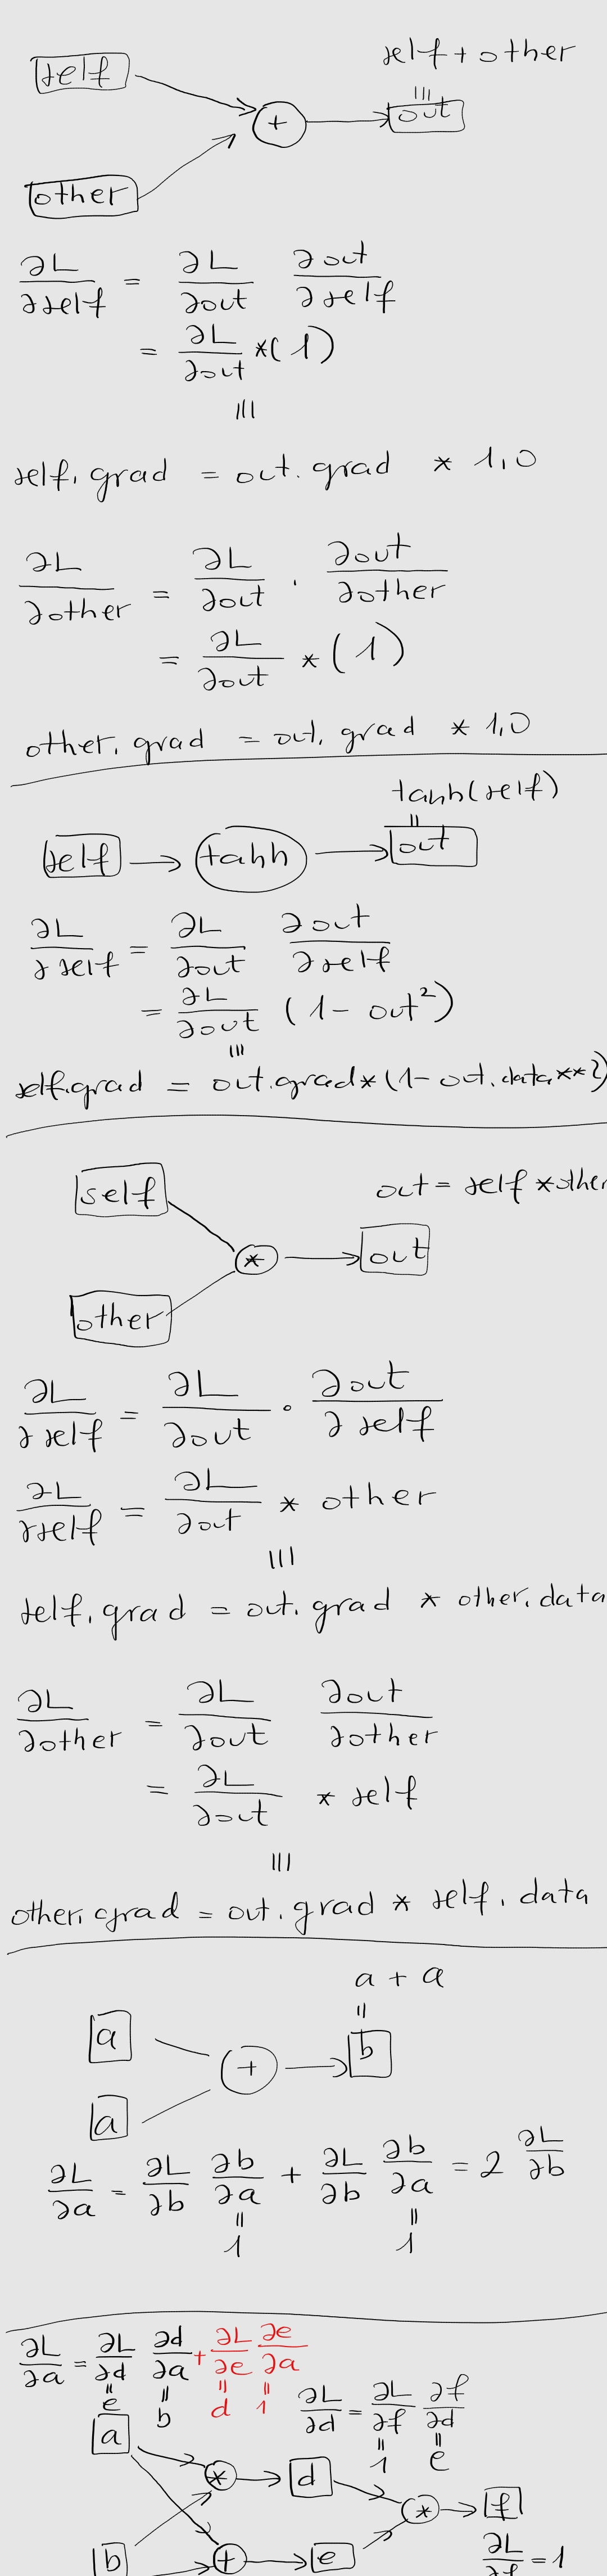

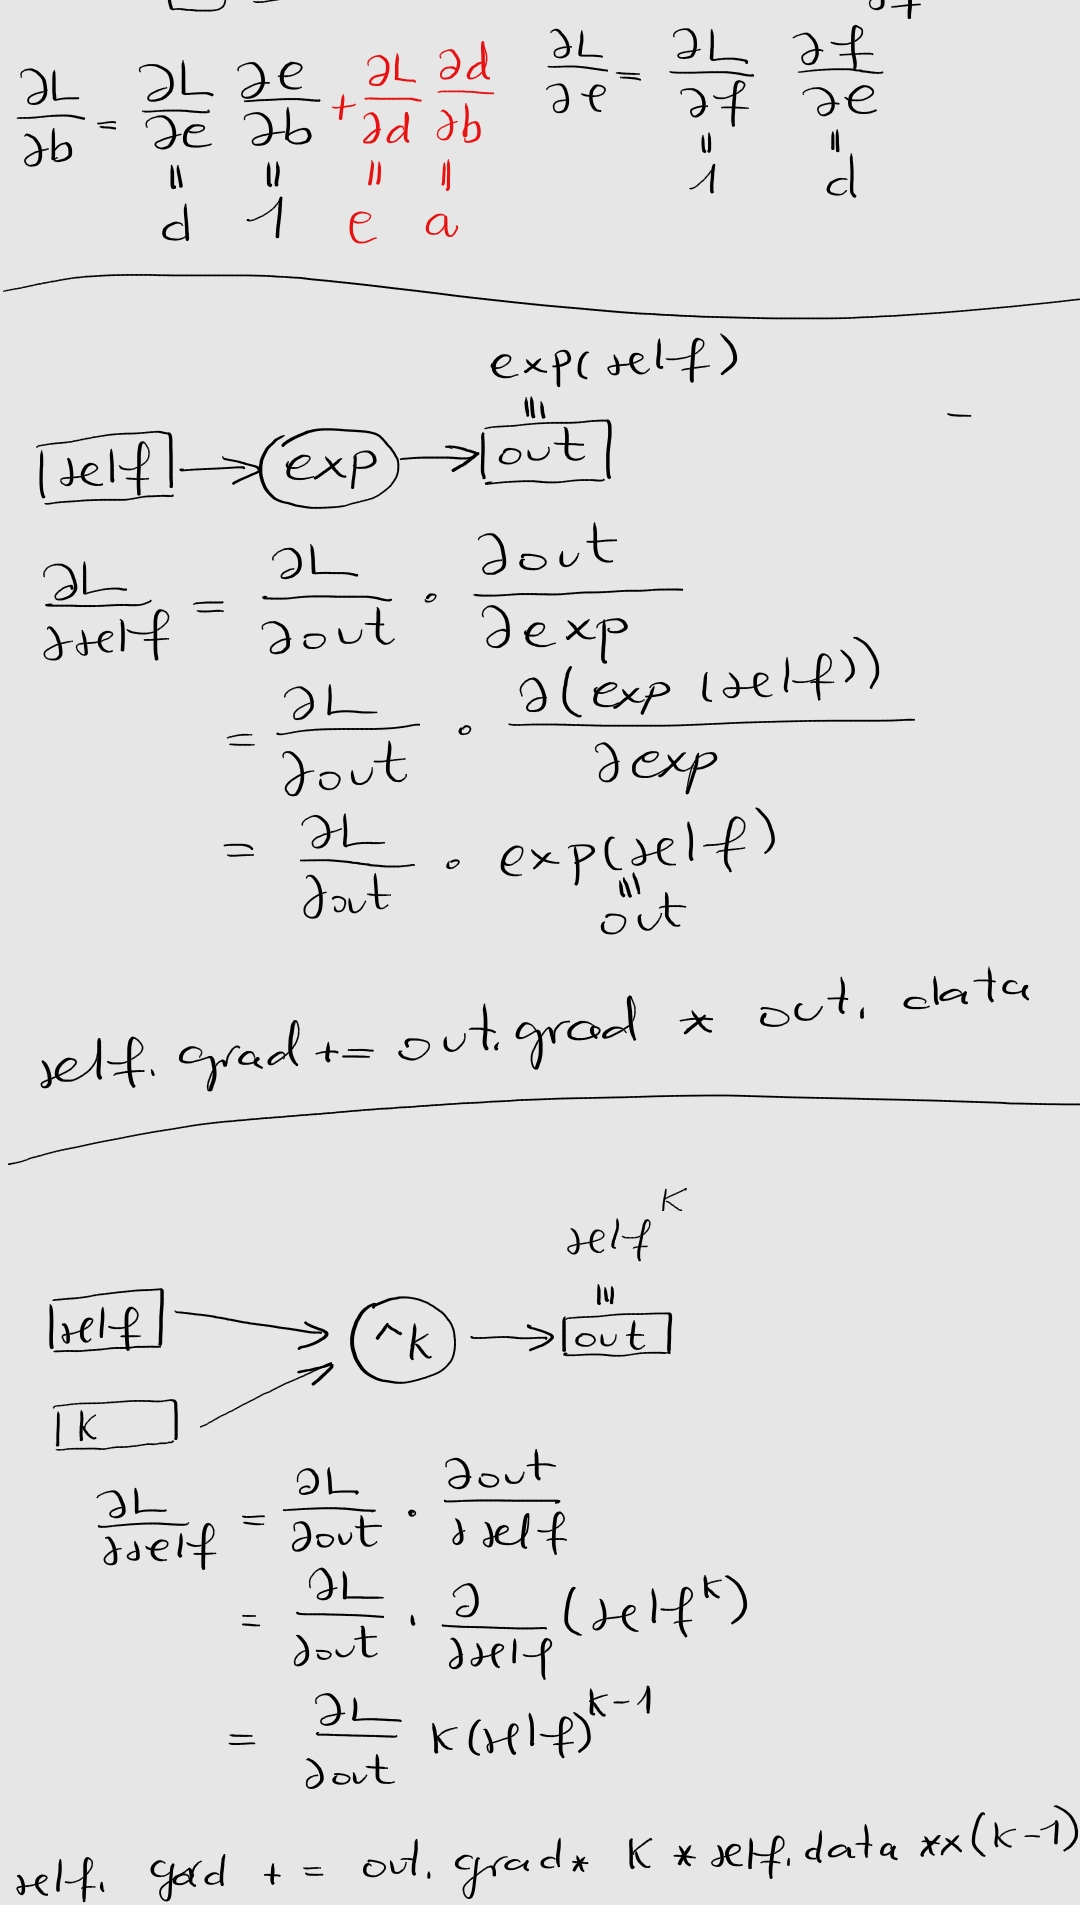

In [ ]:
# Inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# neuron weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# neuron bias
b = Value(6.88127358701, label="b")

# Forward pass
w1x1 = w1 * x1; w1x1.label="w1 * x1"
w2x2 = w2 * x2; w2x2.label="w2 * x2"
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label="w1 * x1 + w2 * x2"
n = w1x1w2x2 + b; n.label="n"

# apply activation function
o = n.tanh(); o.label="o"

In [ ]:
o.grad = 1.0
o._backward()
n._backward()
b._backward()
w1x1w2x2._backward()
w2x2._backward()
w1x1._backward()

In [ ]:
draw_dot(o)

## Implementing a automatic backwardpass

We have to sort nodes in a topological order

In [ ]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0 # 0 means no effect
        self._backward = lambda: None # function will apply the chain rule using the local gradient and grad of child node
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad

        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self, ), "tanh")

        def _backward():
            self.grad = out.grad * (1 - t ** 2) 

        out._backward = _backward

        return out


    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)

                for child_v in v._prev:
                    build_topo(child_v)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [ ]:
# Inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# neuron weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# neuron bias
b = Value(6.88127358701, label="b")

# Forward pass
w1x1 = w1 * x1; w1x1.label="w1 * x1"
w2x2 = w2 * x2; w2x2.label="w2 * x2"
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label="w1 * x1 + w2 * x2"
n = w1x1w2x2 + b; n.label="n"

# apply activation function
o = n.tanh(); o.label="o"

In [ ]:
o.backward()

In [ ]:
draw_dot(o)

## Fixing a bug

In [ ]:
a = Value(data=3, label="a")
b = a + a; b.label="n"

b.backward()
draw_dot(b)

In [ ]:
a = Value(-2.0, label="a")
b = Value(3.0, label="b")
d = a * b; d.label="d"
e = a + b; e.label="e"
f = d * e; f.label="f"

f.backward()
draw_dot(f)

In [ ]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0 # 0 means no effect
        self._backward = lambda: None # function will apply the chain rule using the local gradient and grad of child node
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self, ), "tanh")

        def _backward():
            self.grad += out.grad * (1 - t ** 2) 

        out._backward = _backward

        return out


    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)

                for child_v in v._prev:
                    build_topo(child_v)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [ ]:
a = Value(data=3, label="a")
b = a + a; b.label="n"

b.backward()
draw_dot(b)

In [ ]:
a = Value(-2.0, label="a")
b = Value(3.0, label="b")
d = a * b; d.label="d"
e = a + b; e.label="e"
f = d * e; f.label="f"

f.backward()
draw_dot(f)

## Exercising with more operations

Exercise 1:

```python
def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), "exp")

    def _backward():
        self.grad += """TODO"""

    out._backward = _backward

    return out
```

Exercise 2:

```python
def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int / float powers"
    out = Value(self.data ** other, (self, ), f"**{other}")

    def _backward():
        self.grad += """TODO"""
    out._backward = _backward

    return out
```

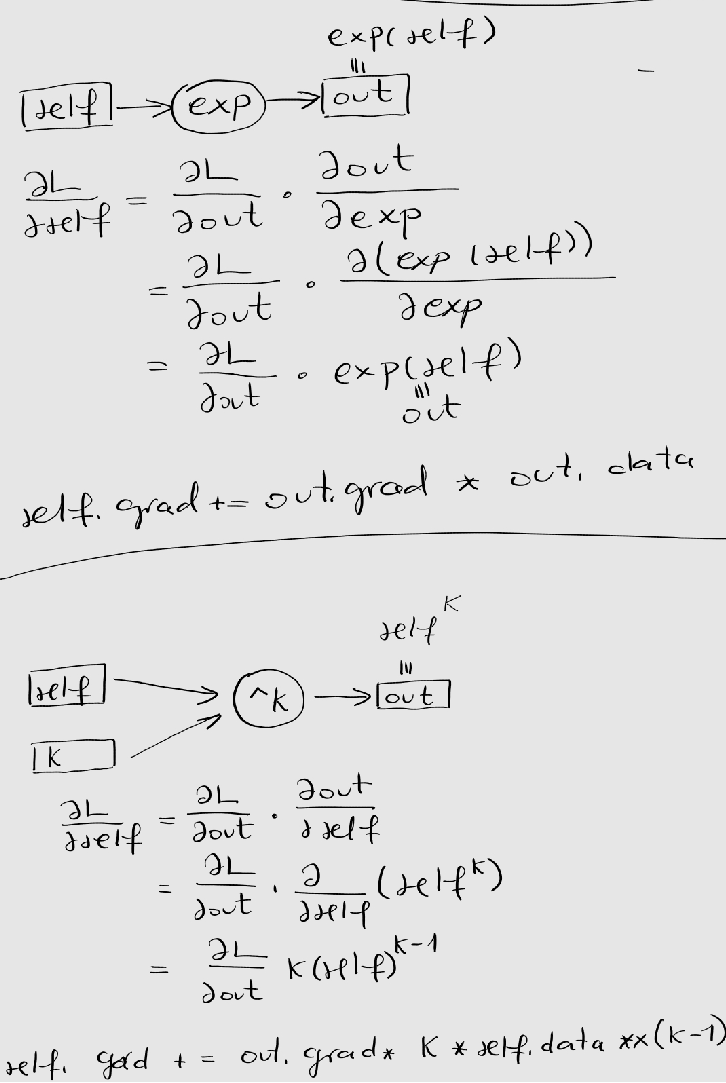

In [ ]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0 # 0 means no effect
        self._backward = lambda: None # function will apply the chain rule using the local gradient and grad of child node
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward

        return out

    def __sub__(self, other):
        return self + (-other)
    
    def __neg__(self):
        return self * (-1)

    def __rmul__(self, other):
        return self * other

    def __ladd__(self, other):
        return self + other

    def __radd__(self, other):
        return self * other

    def __truediv__(self, other):
        return self * other**-1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int / float powers"
        out = Value(self.data ** other, (self, ), f"**{other}")

        def _backward():
            self.grad += out.grad * (other * (self.data ** (other - 1)))
        out._backward = _backward

        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self, ), "tanh")

        def _backward():
            self.grad += out.grad * (1 - t ** 2) 

        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), "exp")

        def _backward():
            self.grad += out.grad * out.data

        out._backward = _backward

        return out


    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)

                for child_v in v._prev:
                    build_topo(child_v)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [ ]:
a = Value(2.0)
b = Value(4.0)
a - b

In [ ]:
# Inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# neuron weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# neuron bias
b = Value(6.88127358701, label="b")

# Forward pass
w1x1 = w1 * x1; w1x1.label="w1 * x1"
w2x2 = w2 * x2; w2x2.label="w2 * x2"
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label="w1 * x1 + w2 * x2"
n = w1x1w2x2 + b; n.label="n"

# apply activation function
o = n.tanh(); o.label="o"

In [ ]:
o.backward()
draw_dot(o)

In [ ]:
# Inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# neuron weights w1, w2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# neuron bias
b = Value(6.88127358701, label="b")

# Forward pass
w1x1 = w1 * x1; w1x1.label="w1 * x1"
w2x2 = w2 * x2; w2x2.label="w2 * x2"
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label="w1 * x1 + w2 * x2"
n = w1x1w2x2 + b; n.label="n"

# apply activation function
####################################
e = (2 * n).exp()
o = (e - 1) / (e + 1) # define tanh using exp functions
o.backward()
draw_dot(o)
####################################

## PyTorch

We'll do the same thing in pytorch. Note that micro-grad works on scalars, whereas pytorch works on tensors.

In [ ]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad=True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad=True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double(); w2.requires_grad = True
b = torch.Tensor([6.88127358701]).double(); b.requires_grad = True
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

# Forward pass
print(f"o: {o.item()}")
o.backward()

# Backward pass
print(f"x1: {x1.grad.item()}")
print(f"w1: {w1.grad.item()}")
print(f"x2: {x2.grad.item()}")
print(f"w2: {w2.grad.item()}")

## Building a neural net library in micrograd

### Forward into a single neuron

In [ ]:
import random

class Neuron:
    def __init__(self, n_in):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(n_in)]
        self.b = Value(random.uniform(-1, 1))


    def __call__(self, x):
        act = sum([w_i * x_i for w_i, x_i in zip(self.w, x)], self.b)
        out = act.tanh()
        return out


In [ ]:
x = [2.0, 3.0]
n = Neuron(len(x))
n(x)

### Layer of neurons

In [ ]:
import random

class Neuron:
    def __init__(self, n_in):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(n_in)]
        self.b = Value(random.uniform(-1, 1))


    def __call__(self, x):
        act = sum([w_i * x_i for w_i, x_i in zip(self.w, x)], self.b)
        out = act.tanh()
        return out

class Layer:
    def __init__(self, n_in, n_out):
        self.neurons = [Neuron(n_in) for _ in range(n_out)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs

In [ ]:
x = [2.0, 3.0]
n = Layer(len(x), 3)
n(x)

### Multilayer perceptron (MLP)

In [ ]:
import random

class Neuron:
    def __init__(self, n_in):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(n_in)]
        self.b = Value(random.uniform(-1, 1))


    def __call__(self, x):
        act = sum([w_i * x_i for w_i, x_i in zip(self.w, x)], self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, n_in, n_out):
        self.neurons = [Neuron(n_in) for _ in range(n_out)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        params = []

        for neuron in self.neurons:
            ps = neuron.parameters()
            params.extend(ps)

        return params

class MLP:
    def __init__(self, n_in, n_outs):
        sz = [n_in] + n_outs
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(n_outs))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)

        return x

    def parameters(self):
        params = []

        for layer in self.layers:
            ps = layer.parameters()
            params.extend(ps)

        return params

In [ ]:
x = [2.0, 3.0, -1.0]
mlp = MLP(3, [4, 4, 1])
mlp(x)

In [ ]:
draw_dot(mlp(x))

## Creating a dataset and writting a loss function

In [ ]:
X = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

y = [1.0, -1.0, -1.0, 1.0]

In [ ]:
mlp = MLP(3, [4, 4, 1])

y_hat = [mlp(x) for x in X]
y_hat

We will implement a MSE loss function

In [ ]:
loss = sum([(y_hat_i - y_i) ** 2 for y_i, y_hat_i in zip(y, y_hat)])
loss

In [ ]:
loss.backward()

In [ ]:
mlp.layers[0].neurons[0].w[0].grad

In [ ]:
mlp.layers[0].neurons[0].w[0].data

In [ ]:
draw_dot(loss)

We can get all of the parameters

In [ ]:
mlp.parameters()

In [ ]:
alpha = 0.01
for param in mlp.parameters():
    param.data = param.data - alpha *  param.grad

In [ ]:
mlp.layers[0].neurons[0].w[0].data

In [ ]:
y_hat = [mlp(x) for x in X]
loss = sum([(y_hat_i - y_i) ** 2 for y_i, y_hat_i in zip(y, y_hat)])
loss

## Training loop

In [ ]:
alpha = 0.05
losses = []

for k in range(50):
    # forward pass
    y_hat = [mlp(x) for x in X]
    loss = sum([(y_hat_i - y_i) ** 2 for y_i, y_hat_i in zip(y, y_hat)])

    for param in mlp.parameters():
        param.grad = 0.0

    loss.backward()

    for param in mlp.parameters():
        param.data = param.data - alpha *  param.grad

    losses.append(loss.data)

In [ ]:
plt.plot(losses)